<a href="https://colab.research.google.com/github/YassineH2j/TP_Machine_Learning/blob/main/MP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import os
import torch
import glob
import numpy as np
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from PIL import Image


In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [66]:
import os
from google.colab import drive  
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Data")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
transformer = transforms.Compose([
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
        [0.5,0.5,0.5])
])
transformer

Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [71]:
train_path = 'TrainData'
test_path = 'TestData'
source_path = 'SourceData'
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [72]:
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes

['benign', 'malignant', 'normal']

In [73]:
test_np = np.array(test_loader.dataset)
test_np

<ipython-input-73-fd1bdd3284ee>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  test_np = np.array(test_loader.dataset)
<ipython-input-73-fd1bdd3284ee>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_np = np.array(test_loader.dataset)


array([[tensor([[[ 0.2784,  0.2706,  0.2784,  ...,  0.0824,  0.0431, -0.0196],
                 [ 0.2784,  0.3020,  0.3020,  ...,  0.1294,  0.0431,  0.0039],
                 [ 0.2784,  0.2941,  0.2627,  ...,  0.2000,  0.1216,  0.0824],
                 ...,
                 [ 0.1529,  0.1922,  0.2627,  ...,  0.0824,  0.0667,  0.0431],
                 [ 0.1373,  0.1451,  0.2000,  ...,  0.0588,  0.0588,  0.0588],
                 [ 0.1373,  0.1373,  0.1608,  ...,  0.0902,  0.0667,  0.0431]],

                [[ 0.2784,  0.2706,  0.2784,  ...,  0.0824,  0.0431, -0.0196],
                 [ 0.2784,  0.3020,  0.3020,  ...,  0.1294,  0.0431,  0.0039],
                 [ 0.2784,  0.2941,  0.2627,  ...,  0.2000,  0.1216,  0.0824],
                 ...,
                 [ 0.1529,  0.1922,  0.2627,  ...,  0.0824,  0.0667,  0.0431],
                 [ 0.1373,  0.1451,  0.2000,  ...,  0.0588,  0.0588,  0.0588],
                 [ 0.1373,  0.1373,  0.1608,  ...,  0.0902,  0.0667,  0.0431]],

    

In [76]:
import requests
from pathlib import Path 
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


helper_functions.py already exists, skipping download


In [78]:
class ModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, 
                      out_channels = hidden_units, 
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, 
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=10240, 
                out_features=output_shape)
        )
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.dropout(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_2 = ModelV2(input_shape=3, 
    hidden_units = 10, 
    output_shape = len(classes)).to(device)
model_2


ModelV2(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=3, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

In [81]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_2.parameters(),lr = 0.001,weight_decay = 0.0001)

In [82]:
train_count = len(glob.glob(train_path+'/**/*.png'))
test_count = len(glob.glob(test_path+'/**/*.png'))

In [83]:
print(train_count,test_count)

24 24


In [84]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [85]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [86]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)
train_time_start_model_2 = timer()
epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model = model_2, 
        loss_fn = loss_fn,
        optimizer = optimizer,
        accuracy_fn = accuracy_fn,
        device = device
    )
    test_step(data_loader=test_loader,
        model = model_2,
        loss_fn = loss_fn,
        accuracy_fn = accuracy_fn,
        device = device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start = train_time_start_model_2,
                                           end = train_time_end_model_2,
                                           device = device)
[0.8219,0.8367,0.8469,0.8532,0.8527,0.8536,0.8590,0.8643,0.8612,0.8647,0.8690,0.8751,0.8840,0.8853,0.8959,0.9032,0.9144,0.9170,0.9293,0.9309]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09880 | Train accuracy: 37.50%
Test loss: 1.12583 | Test accuracy: 33.33%

Epoch: 1
---------
Train loss: 1.12109 | Train accuracy: 33.33%
Test loss: 1.10139 | Test accuracy: 33.33%

Epoch: 2
---------
Train loss: 1.09232 | Train accuracy: 33.33%
Test loss: 1.10440 | Test accuracy: 33.33%

Epoch: 3
---------
Train loss: 1.08909 | Train accuracy: 45.83%
Test loss: 1.11282 | Test accuracy: 33.33%

Epoch: 4
---------
Train loss: 1.08740 | Train accuracy: 33.33%
Test loss: 1.10814 | Test accuracy: 33.33%

Epoch: 5
---------
Train loss: 1.06945 | Train accuracy: 45.83%
Test loss: 1.10125 | Test accuracy: 33.33%

Epoch: 6
---------
Train loss: 1.04799 | Train accuracy: 54.17%
Test loss: 1.10053 | Test accuracy: 29.17%

Epoch: 7
---------
Train loss: 1.02898 | Train accuracy: 54.17%
Test loss: 1.10570 | Test accuracy: 25.00%

Epoch: 8
---------
Train loss: 1.00978 | Train accuracy: 58.33%
Test loss: 1.11275 | Test accuracy: 33.33%

Epoch: 9
---------
Train los

[0.8219,
 0.8367,
 0.8469,
 0.8532,
 0.8527,
 0.8536,
 0.859,
 0.8643,
 0.8612,
 0.8647,
 0.869,
 0.8751,
 0.884,
 0.8853,
 0.8959,
 0.9032,
 0.9144,
 0.917,
 0.9293,
 0.9309]

In [91]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc
           }


In [92]:
results = eval_model(
    model_2,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
results

{'model_name': 'ModelV2',
 'model_loss': 1.4567934274673462,
 'model_acc': 45.83333333333333}

In [93]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())            
    return torch.stack(pred_probs)

In [94]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_np), k=20):
    test_samples.append(sample)
    test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[5]} ({classes[test_labels[5]]})")

Test sample image shape: torch.Size([3, 128, 128])
Test sample label: 2 (normal)


In [96]:
pred_probs= make_predictions(model=model_2, data=test_samples)
pred_probs

tensor([[0.3375, 0.0086, 0.6538],
        [0.1336, 0.2334, 0.6331],
        [0.8485, 0.0420, 0.1095],
        [0.6165, 0.1786, 0.2050],
        [0.6082, 0.1326, 0.2592],
        [0.3461, 0.2926, 0.3613],
        [0.3485, 0.3448, 0.3067],
        [0.1868, 0.0360, 0.7772],
        [0.0965, 0.8730, 0.0305],
        [0.5204, 0.0927, 0.3869],
        [0.1582, 0.1968, 0.6450],
        [0.4261, 0.0145, 0.5595],
        [0.4434, 0.2637, 0.2929],
        [0.0679, 0.0031, 0.9291],
        [0.2822, 0.0080, 0.7099],
        [0.5162, 0.0365, 0.4473],
        [0.3255, 0.3114, 0.3631],
        [0.1326, 0.0177, 0.8497],
        [0.2322, 0.4801, 0.2877],
        [0.5678, 0.1022, 0.3300]])

In [97]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 2, 0, 0, 0, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1, 0])

In [98]:
test_labels, pred_classes

([0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 2, 2, 1, 0, 2, 1, 2],
 tensor([2, 2, 0, 0, 0, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1, 0]))

In [99]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
  exist_ok=True
)
MODEL_NAME = "model_2_20ep_adam_dropout_pre.pth"
MODEL_PKL = "model_2_20ep_pre"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
PKL = MODEL_PATH / MODEL_PKL
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_2_20ep_adam_dropout_pre.pth


In [101]:
torch.save(obj = model_2, f = PKL)

In [102]:
NAME = "model_2_20ep_adam_dropout.pth"
MODEL_SAVE_PATH = MODEL_PATH / NAME
loaded_model = ModelV2(input_shape=3, 
    hidden_units=10, 
    output_shape=len(classes)).to(device)
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [105]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [106]:
from PIL import Image
img = Image.open("/content/drive/MyDrive/Data/SourceData/1000.png").convert('RGB')

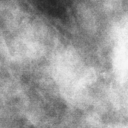

In [107]:
img

In [108]:
input = transform(img)

In [109]:
input = input.unsqueeze(0)

In [110]:
loaded_model.eval()

ModelV2(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=3, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

In [111]:
output = loaded_model(input)

In [112]:
pred_prob = torch.softmax(output.squeeze(), dim=0)

In [113]:
pred = pred_prob.argmax()

In [114]:
pred

tensor(2)